# Three investigators - part II

A project for scraping and analysing data from a fan site on the audio book called '[The three investigators](https://en.wikipedia.org/wiki/Three_Investigators#Germany)'

Part II: Data preparation and explorative analysis

- additional data cleaning and preparing for analysis
- explorative analysis of data
- prediction of episode ratings

# Setup

In [1]:
#python version used for this project
from platform import python_version
print(python_version())

In [2]:
# import modules [as specified in requirements.txt]
import pandas as pd
import numpy as np
import re
import requests
from datetime import date
import matplotlib.pyplot as plt

# for file directories
import os

%matplotlib inline

In [3]:
#change directory to root folder
os.chdir("..")

# Load data

In [4]:
#load scraped datafiles
meta = pd.read_csv(".\\data\\scraped\\meta.csv")
actors = pd.read_csv(".\\data\\scraped\\actor_all.csv")
content = pd.read_csv(".\\data\\scraped\\content_all.csv")
rating = pd.read_csv(".\\data\\scraped\\rating.csv")

#load title analysis
title_counts = pd.read_csv(".\\data\\processed\\title_word_count.csv")
title_cat = pd.read_csv(".\\data\\processed\\title_categories.csv")

#load actor gender prediction
gender = pd.read_csv(".\\data\\processed\\actor_gender_prediction_2020-09-28.csv")

In [5]:
meta.shape

(206, 44)

# Data cleaning and prep

## add/remove episodes from tables

In [6]:
### add episode 29 details to meta table (https://www.rocky-beach.com/hoerspiel/folgen/029.html)
meta = meta.append({'id' : 29, 'music': 'B. Brac/B. George', 'date':'1982-03-21', 
                     'minutes': '34', 'minutes_mean':34, 'minutes_total':34, 'parts':1} , ignore_index=True)

## remove 29 from actors table
actors = actors.loc[actors["id"] != 29]

### Remove duplicates from actor_all table
actors = actors.drop_duplicates()

## Gender predictions

In [7]:
actors

,role,actor,id,actor_clean,title,firstname,surename,no_names,main_actor,narrator
0,Hitchcock,Peter Pasetti,1,Peter Pasetti,0,Peter,Pasetti,2,0,1
1,Justus Jonas,Oliver Rohrbeck,1,Oliver Rohrbeck,0,Oliver,Rohrbeck,2,1,0
2,Peter Shaw,Jens Wawrczeck,1,Jens Wawrczeck,0,Jens,Wawrczeck,2,1,0
3,Bob Andrews,Andreas Fröhlich,1,Andreas Fröhlich,0,Andreas,Fröhlich,2,1,0
4,"Mr. Fentriss, Schriftsteller",Richard Lauffen,1,Richard Lauffen,0,Richard,Lauffen,2,0,0
...,...,...,...,...,...,...,...,...,...,...
2868,Ron Baxter,Robin Brosch,207,Robin Brosch,0,Robin,Brosch,2,0,0
2869,Oma,Apollonia Jepsen,207,Apollonia Jepsen,0,Apollonia,Jepsen,2,0,0
2870,Mrs. Willard,Daniela Ziegler,207,Daniela Ziegler,0,Daniela,Ziegler,2,0,0
2871,Li,Traudel Sperber,207,Traudel Sperber,0,Traudel,Sperber,2,0,0


In [8]:
# join tables
actors = pd.merge(actors, gender, left_on='firstname', right_on = "name", how="left")
actors = actors.drop("name", axis=1)
actors.head()

,role,actor,id,actor_clean,title,firstname,surename,no_names,main_actor,narrator,Unnamed: 0,gender,gender_probability,gender_count
0,Hitchcock,Peter Pasetti,1,Peter Pasetti,0,Peter,Pasetti,2,0,1,1.0,male,0.99,165452.0
1,Justus Jonas,Oliver Rohrbeck,1,Oliver Rohrbeck,0,Oliver,Rohrbeck,2,1,0,1.0,male,0.99,32776.0
2,Peter Shaw,Jens Wawrczeck,1,Jens Wawrczeck,0,Jens,Wawrczeck,2,1,0,1.0,male,0.99,23807.0
3,Bob Andrews,Andreas Fröhlich,1,Andreas Fröhlich,0,Andreas,Fröhlich,2,1,0,1.0,male,0.99,71365.0
4,"Mr. Fentriss, Schriftsteller",Richard Lauffen,1,Richard Lauffen,0,Richard,Lauffen,2,0,0,1.0,male,0.99,101928.0


In [9]:
# get list of names that have not been classified with a gender
actors.loc[actors["gender"].isna()]["firstname"].unique()

array(['Heikedine', 'Reinhilt', 'Joyceline', 'H.', 'Schiffmeister', '...',
       'Rosakutty', 'Gustav-Adolph', 'Rhesi', 'é', 'Jörgpeter'],
      dtype=object)

In [10]:
## classify gender of missing ones (if known)
actors.loc[actors["firstname"] == 'Heikedine', "gender"] = "female"
actors.loc[actors["firstname"] == 'Reinhilt', "gender"] = "female"
actors.loc[actors["firstname"] == 'Gustav-Adolph', "gender"] = "male"
actors.loc[actors["firstname"] == 'Jörgpeter', "gender"] = "male"
actors.loc[actors["firstname"] == 'Rhesi', "gender"] = "female"
actors.loc[actors["firstname"] == 'é', "gender"] = "male"

## Add to meta data

In [11]:
## Create year and month column
meta["year"] = pd.DatetimeIndex(meta["date"]).year
meta["month"] = pd.DatetimeIndex(meta["date"]).month

### Number of actors, main and side

In [12]:
actors_agg = pd.DataFrame(actors.groupby("id")[["actor", "main_actor", "narrator"]].agg(
    {"actor": "count", "main_actor":"sum", "narrator": "max"})).reset_index()
actors_agg = actors_agg.rename(columns={"actor":"no_actors_total", "main_actor":"no_main_actors"})
actors_agg["no_side_actors"] = actors_agg["no_actors_total"] - actors_agg["no_main_actors"] - actors_agg["narrator"] #also remove narrator

#join with meta
meta = pd.merge(meta, actors_agg, left_on="id" ,right_on="id", how='left')

In [13]:
list(meta)

['id',
 '"anudhara" aufgenommen bei bantree records, worms / produzent',
 'buch',
 'buch und effekte',
 'buch und redaktion',
 'cover-illustration',
 'coverillustration',
 'design',
 'effekte und redaktion',
 'erscheinungsdatum',
 'erzählt von',
 'geräusche',
 'ger�usche',
 'hörspielbearbeitung',
 'klang-recycling',
 'laufzeit',
 'musik',
 'musik und effekte',
 'nessie der seltsame wecker matthias green recyclings aus 3 fragezeichen rap',
 'produktion und regie',
 'projektleitung und produktmanagement',
 'redaktion',
 'redaktion und geräusche',
 'regie',
 'regie und produktion',
 'song',
 'teil a erzählt von',
 'teil b erzählt von',
 'teil c erzählt von',
 'titel',
 'titelmusik',
 'html',
 'zur vorherigen folge | zur nächsten folge',
 'book',
 'cover',
 'music',
 'director',
 'editor',
 'sounds',
 'date',
 'minutes',
 'minutes_mean',
 'minutes_total',
 'parts',
 'year',
 'month',
 'no_actors_total',
 'no_main_actors',
 'narrator',
 'no_side_actors']

### Gender balance all actors

In [14]:
actors_gender = actors.groupby(["id", "gender"])["role"].count()
actors_gender = pd.DataFrame(actors_gender).unstack().fillna(0).reset_index("id")
actors_gender.columns = actors_gender.columns.droplevel(level=0)
actors_gender = actors_gender.rename(columns={"": "id", "female": "no_female_actors", "male": "no_male_actors"})

#join with meta
meta = pd.merge(meta, actors_gender, left_on="id" ,right_on="id", how='left')

#gender missing
meta["no_actor_gender_missing"] = meta["no_actors_total"] - meta[["no_female_actors", "no_male_actors"]].sum(axis=1)

#gender balance for all actors
meta["female_actors_ratio"] = meta["no_female_actors"] / meta[["no_female_actors", "no_male_actors"]].sum(axis=1) *100

### Gender balance side actors

In [15]:
filter_side_actors = (actors["narrator"] == 0) & (actors["main_actor"] == 0)
side_actors_gender = actors.loc[filter_side_actors].groupby(["id", "gender"])["role"].count()
side_actors_gender = pd.DataFrame(side_actors_gender).unstack().fillna(0).reset_index("id")
side_actors_gender.columns = side_actors_gender.columns.droplevel(level=0)
side_actors_gender = side_actors_gender.rename(columns={"": "id", "female": "no_female_side_actors", "male": "no_male_side_actors"})

#join with meta
meta = pd.merge(meta, side_actors_gender, left_on="id" ,right_on="id", how='left')

#gender balance for side actors
meta["female_side_actors_ratio"] = meta["no_female_side_actors"] / meta[["no_female_side_actors", "no_male_side_actors"]].sum(axis=1) *100

### Narrator

In [16]:
narrator = actors.loc[actors["narrator"]==1][["id","actor_clean"]]
narrator = narrator.rename(columns={"actor_clean": "narrator_name"})

#join with meta
meta = pd.merge(meta, narrator, left_on="id" ,right_on="id", how='left')

### Author

In [17]:
#replace 'Erzählt von Kari Erlhoff' with 'Kari Erlhoff'
meta["erzählt von"] = meta["erzählt von"].str.replace('Erzählt von Kari Erlhoff', 'Kari Erlhoff')

In [18]:
# group authors
meta["author_grouped"] = meta["erzählt von"]

# group those authors with fewer than 5 episodes under 'other'
other_storytellers = pd.DataFrame(meta["erzählt von"].value_counts()).reset_index()
other_storytellers = other_storytellers.loc[other_storytellers["erzählt von"] < 5]["index"].tolist()
meta.loc[meta["erzählt von"].isin(other_storytellers), "author_grouped"] = "Other"

#display values
meta["author_grouped"].value_counts()

André Marx                           33
Marco Sonnleitner                    32
Ben Nevis                            22
Other                                18
Brigitte Johanna Henkel-Waidhofer    16
M.V. Carey                           15
William Arden                        14
Kari Erlhoff                         13
André Minninger                      12
Robert Arthur                        10
Astrid Vollenbruch                    7
Christoph Dittert                     7
Hendrik Buchna                        6
Name: author_grouped, dtype: int64

In [19]:
# create gender variable
author_gender_map = {'Robert Arthur': "male", 'William Arden': "male", 'M.V. Carey':"female",
                     'Nick West':"male", 'Marc Brandel':"male", 'Rose Estes':"female", 
                     'Megan Stine / H. William Stine': np.nan,
                   'G.H. Stone':"female", 'William McCay' : "male", 'Peter Lerangis' : "male",
                   'Brigitte Johanna Henkel-Waidhofer' : "female", 'André Marx' : "male",
                    'André Minninger' : "male", 'Ben Nevis': "male", 'Katharina Fischer': "female",
                   'Marco Sonnleitner' :"male", 'Astrid Vollenbruch': "female", 'Kari Erlhoff' : "female",
                  'Hendrik Buchna': "male", 'Christoph Dittert':"male"}

meta["author_gender"] = meta["erzählt von"].map(author_gender_map)

### merge rating

In [20]:
#rename columns in rating table
rating = rating.rename(columns={"bewertung.1" : "rating", "rang": "rating_rank", "ranking": "no_votes"})

#join with meta table
meta = pd.merge(meta, rating, left_on="id" ,right_on="id", how='left')

### title

In [21]:
# merge title categories into meta data
meta = meta.merge(title_cat, left_on="id", right_on="id", how='left' )

In [22]:
# clean up titel

## make titles lower case
meta["title"] = meta["titel"].str.lower()

meta["title"] = meta["title"].str.replace("hörspiel", "", regex=True).str.replace("[!\"#$%&()*+,./:;<=>?@[\]^_`{|}~“”-]", "", regex=True)

### Create column for number of episode published in each year

In [23]:
numbered = []

for i in range(len(meta["year"])): 
    if i == 0:
        x = 1
    elif meta["year"][i] == meta["year"][i-1]:
        x +=1
    else:
        x = 1
    numbered.append(x)
    
meta["no_per_year"] = numbered

### save output

In [24]:
### order by id and reset index
meta = meta.sort_values("id").reset_index(drop=True)

### save output
meta.to_csv(".\\data\\processed\\meta_for_analysis_" + "%s" %(str(date.today())) + ".csv", index=False) 

# Explorative Analysis

## Exports for charts

In [71]:
chrono = meta[["id", "year", "month", "no_per_year", "minutes_mean", 
               "parts", "title_sport", "title_tech", "title", "erzählt von", "rating"]]
chrono[["minutes_mean"]] = chrono[["minutes_mean"]].round(0)
chrono[["rating"]] = chrono[["rating"]].round(1)
chrono.to_csv(".\\data\\processed\\chrono-datawrapper.csv")

## Chronology

In [26]:
years = meta.groupby("year")[["parts", "minutes_mean", "id"]].agg({
    "parts": ["sum"], "minutes_mean" : ["mean", "min", "max"], "id": ["count","min", "max"]})
years.columns = ["_".join(x) for x in years.columns.ravel()]
years = years.reset_index().rename(columns={"minutes_mean_mean": "minutes_mean",
                              "minutes_mean_min": "minutes_min", "minutes_mean_max":"minutes_max"}) 
years.head()

,year,parts_sum,minutes_mean,minutes_min,minutes_max,id_count,id_min,id_max
0,1979,9,45.555556,43.0,50.0,9,1,9
1,1980,12,42.416667,38.0,49.0,12,10,21
2,1981,6,43.666667,41.0,49.0,6,22,27
3,1982,3,39.333333,34.0,44.0,3,28,30
4,1983,3,43.666667,40.0,49.0,3,31,33


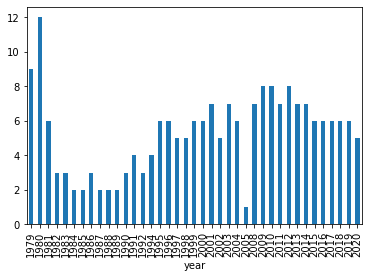

In [27]:
#number of episodes over time
meta.groupby("year")["id"].count().plot(kind='bar')

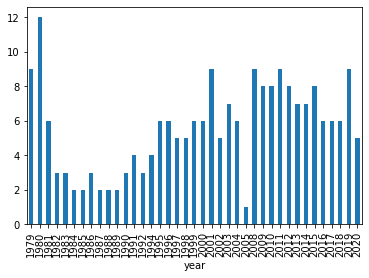

In [28]:
#number of episodes over time
years.set_index("year")["parts_sum"].plot(kind='bar')

### Length

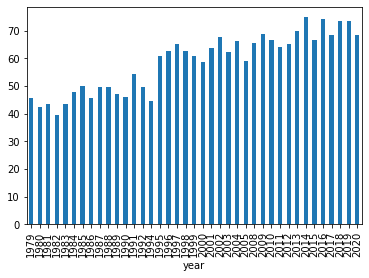

In [29]:
#Average length over time
meta.groupby("year")["minutes_mean"].mean().plot(kind='bar')

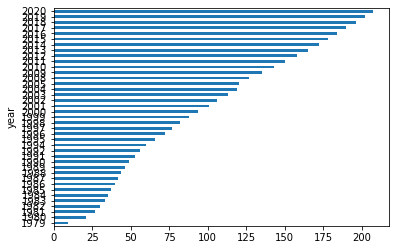

In [30]:
#number of episodes over time
years.set_index("year")["id_max"].plot(kind='barh')

### dotplot

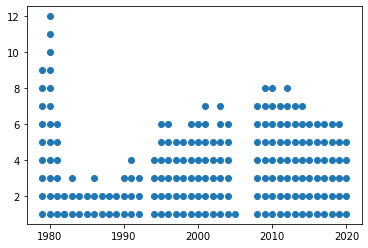

In [31]:
x = meta["year"]
y = meta["no_per_year"]
z = meta["parts"]

plt.scatter(x, y)

### Month

October is the most popular release month but mainly because of the first two years when 15 episodes were released in October.

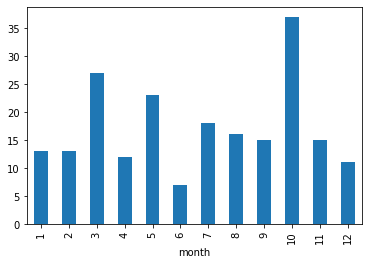

In [32]:
meta.groupby("month")["id"].count().plot(kind='bar')

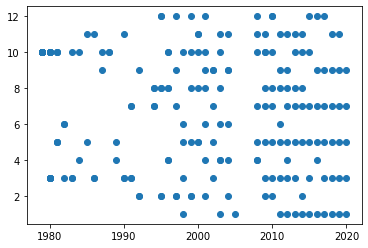

In [33]:
x = meta["year"]
y = meta["month"]

plt.scatter(x, y)

In [34]:
meta.groupby(["year", "month"])["id"].count()

year  month
1979  10       9
1980  3        6
      10       6
1981  5        3
      10       3
              ..
2020  1        1
      3        1
      5        1
      7        1
      9        1
Name: id, Length: 159, dtype: int64

## Author

In [35]:
meta["minutes_mean"].dtype

dtype('float64')

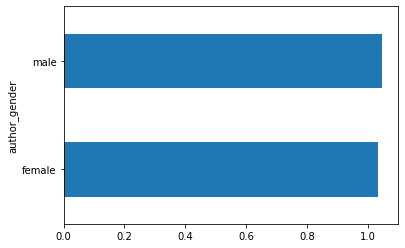

In [36]:
meta.groupby("author_gender")["parts"].mean().plot(kind='barh')

## Actors

In [87]:
roles_filter = ["Bob Andrews", "Peter Shaw", "Justus Jonas", "Erzähler", "Hitchcock", 
             "Inspektor Cotta", "Tante Mathilda", "Onkel Titus", "Morton", 
             "Kommissar Reynolds", "Goodween", "Mr. Andrews","Skinny Norris",
             "Kelly", "Patrick", "Mrs. Shaw", "Lys", "Mrs. Andrews", "Mr. Shaw"]

roles = actors.loc[actors["role"].isin(roles)_filter]

In [88]:
roelsroles.groupby("role")["id"].count().sort_values(ascending = False)

role
Bob Andrews           206
Justus Jonas          206
Peter Shaw            206
Erzähler              131
Hitchcock              75
Inspektor Cotta        67
Tante Mathilda         51
Onkel Titus            31
Morton                 24
Kommissar Reynolds     20
Goodween               17
Mr. Andrews            15
Skinny Norris          12
Kelly                   9
Mrs. Shaw               6
Patrick                 6
Mr. Shaw                5
Lys                     5
Mrs. Andrews            5
Name: id, dtype: int64

In [90]:
roles_dummy = roles[["role", "id"]]
roles_dummy

,role,id
0,Hitchcock,1
1,Justus Jonas,1
2,Peter Shaw,1
3,Bob Andrews,1
11,Morton,1
...,...,...
2818,Inspektor Cotta,206
2822,Erzähler,207
2823,Justus Jonas,207
2824,Peter Shaw,207


In [86]:
roles = pd.DataFrame(actors.groupby("role")["id"].count().sort_values(ascending = False))
roles.iloc[:30]

,id
role,
Bob Andrews,206
Peter Shaw,206
Justus Jonas,206
Erzähler,131
Hitchcock,75
Inspektor Cotta,67
Tante Mathilda,51
Onkel Titus,31
Morton,24


In [38]:
list(actors)

['role',
 'actor',
 'id',
 'actor_clean',
 'title',
 'firstname',
 'surename',
 'no_names',
 'main_actor',
 'narrator',
 'Unnamed: 0',
 'gender',
 'gender_probability',
 'gender_count']

## Gender

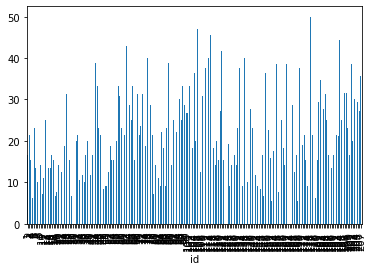

In [39]:
#number of episodes over time
meta.set_index("id")["female_actors_ratio"].plot(kind='bar')

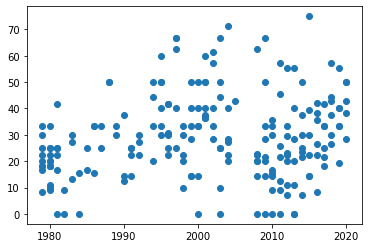

In [40]:
x = meta["year"]
y = meta["female_side_actors_ratio"]

plt.scatter(x, y)

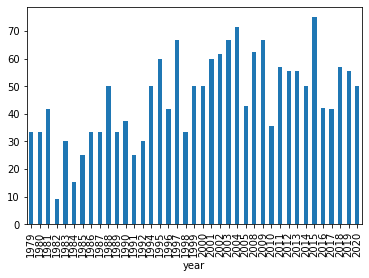

In [41]:
meta.groupby("year")["female_side_actors_ratio"].max().plot(kind='bar')

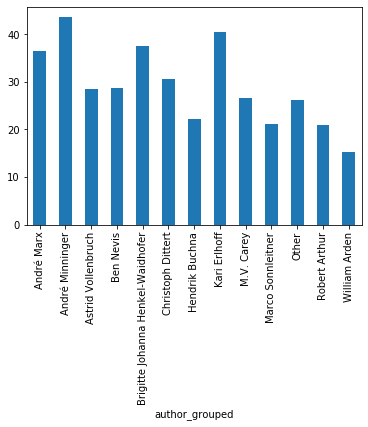

In [42]:
meta.groupby("author_grouped")["female_side_actors_ratio"].mean().plot(kind='bar')

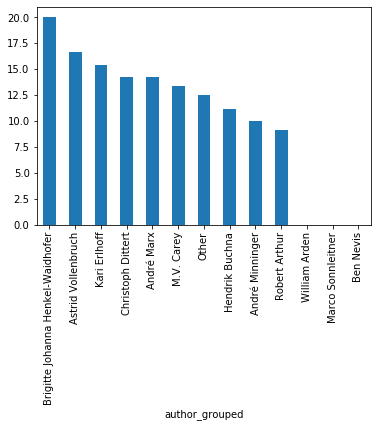

In [43]:
meta.groupby("author_grouped")["female_side_actors_ratio"].min().sort_values(ascending=False).plot(kind='bar')

## titles

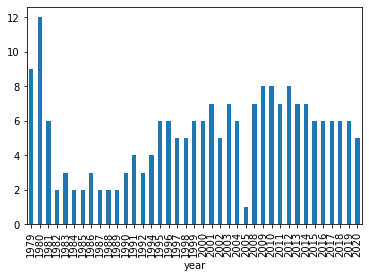

In [44]:
meta.groupby("year")["title_colour"].count().plot(kind='bar')

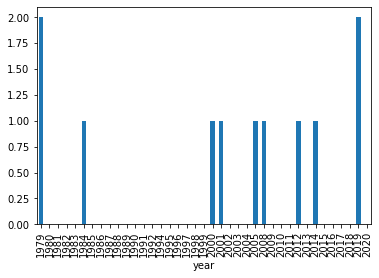

In [45]:
meta.groupby("year")["title_colour"].sum().plot(kind='bar')

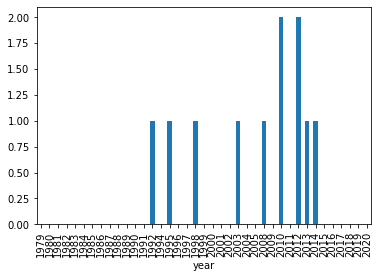

In [46]:
meta.groupby("year")["title_sport"].sum().plot(kind='bar')

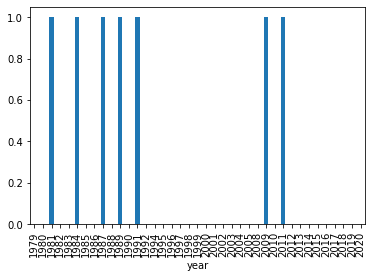

In [47]:
meta.groupby("year")["title_ethnic"].sum().plot(kind='bar')

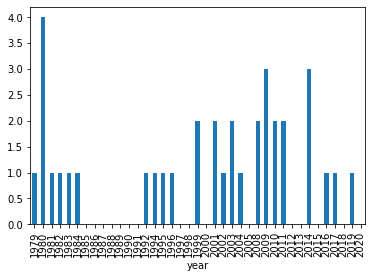

In [48]:
meta.groupby("year")["title_place"].sum().plot(kind='bar')

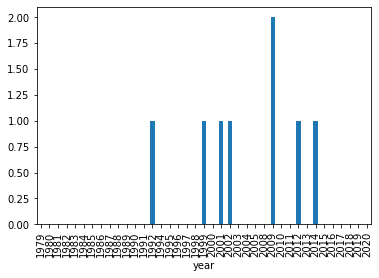

In [49]:
meta.groupby("year")["title_tech"].sum().plot(kind='bar')

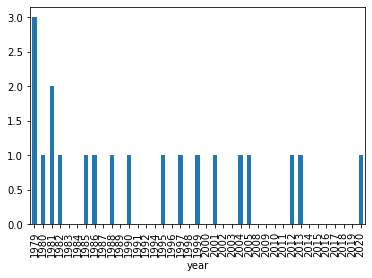

In [50]:
meta.groupby("year")["title_animal"].sum().plot(kind='bar')

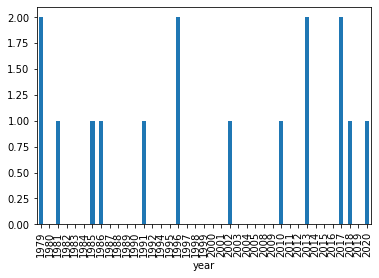

In [51]:
meta.groupby("year")["title_mystery"].sum().plot(kind='bar')

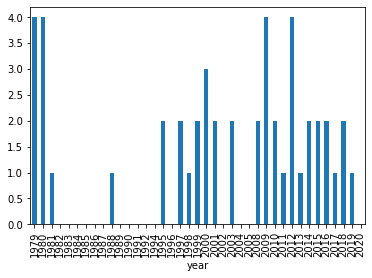

In [52]:
meta.groupby("year")["title_paranormal"].sum().plot(kind='bar')

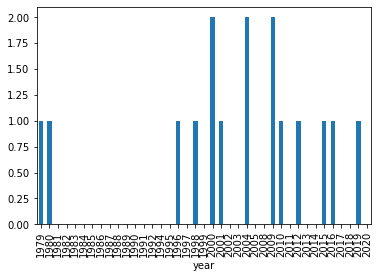

In [53]:
meta.groupby("year")["title_death"].sum().plot(kind='bar')

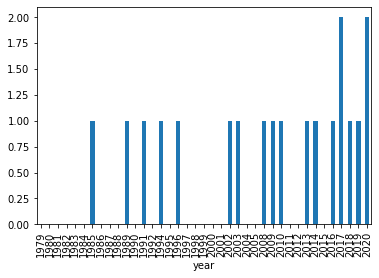

In [54]:
meta.groupby("year")["title_person"].sum().plot(kind='bar')

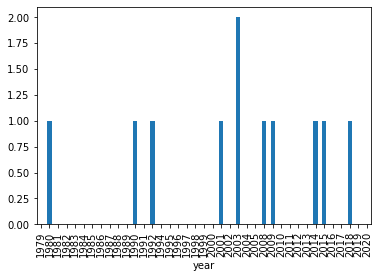

In [55]:
meta.groupby("year")["title_danger"].sum().plot(kind='bar')

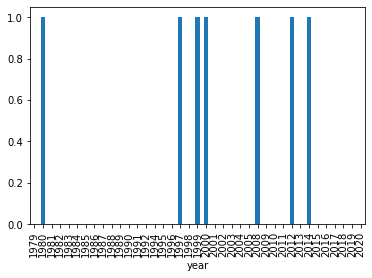

In [56]:
meta.groupby("year")["title_fire"].sum().plot(kind='bar')

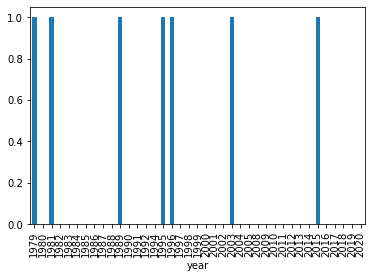

In [57]:
meta.groupby("year")["title_treasure"].sum().plot(kind='bar')

## Rating

In [58]:
rating.columns

Index(['episode', 'rating', 'rating_rank', 'no_votes', 'id', 'source'], dtype='object')

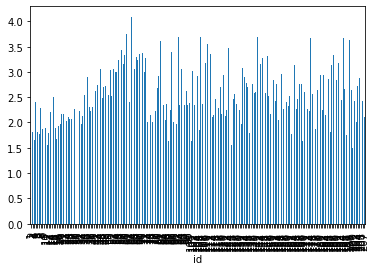

In [59]:
#number of episodes over time
meta.set_index("id")["rating"].plot(kind='bar')

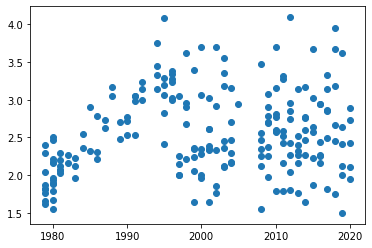

In [60]:
x = meta["year"]
y = meta["rating"]

plt.scatter(x, y)

In [61]:
meta.shape

(207, 81)

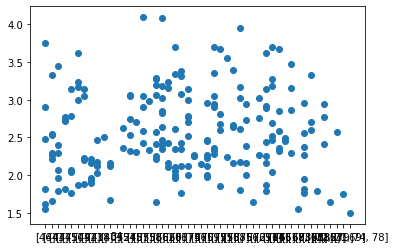

In [62]:
x = meta["minutes"]
y = meta["rating"]

plt.scatter(x, y)

In [63]:
meta.columns

Index(['id', '"anudhara" aufgenommen bei bantree records, worms / produzent',
       'buch', 'buch und effekte', 'buch und redaktion', 'cover-illustration',
       'coverillustration', 'design', 'effekte und redaktion',
       'erscheinungsdatum', 'erzählt von', 'geräusche', 'ger�usche',
       'hörspielbearbeitung', 'klang-recycling', 'laufzeit', 'musik',
       'musik und effekte',
       'nessie der seltsame wecker matthias green recyclings aus 3 fragezeichen rap',
       'produktion und regie', 'projektleitung und produktmanagement',
       'redaktion', 'redaktion und geräusche', 'regie', 'regie und produktion',
       'song', 'teil a erzählt von', 'teil b erzählt von',
       'teil c erzählt von', 'titel', 'titelmusik', 'html',
       'zur vorherigen folge | zur nächsten folge', 'book', 'cover', 'music',
       'director', 'editor', 'sounds', 'date', 'minutes', 'minutes_mean',
       'minutes_total', 'parts', 'year', 'month', 'no_actors_total',
       'no_main_actors', 'narrator',

### Author

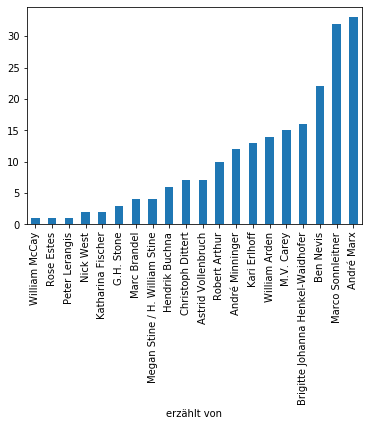

In [64]:
meta.groupby("erzählt von")["rating"].count().sort_values().plot(kind='bar')

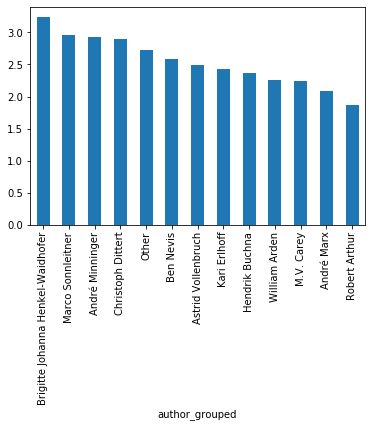

In [65]:
meta.groupby("author_grouped")["rating"].mean().sort_values(ascending=False).plot(kind='bar')

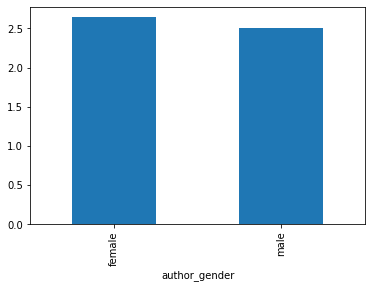

In [66]:
meta.groupby("author_gender")["rating"].mean().plot(kind='bar')

### Actors

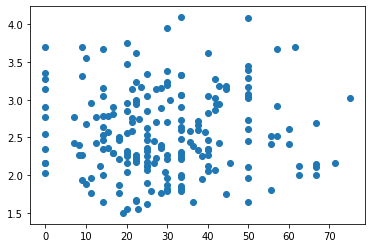

In [67]:
x = meta["female_side_actors_ratio"]
y = meta["rating"]

plt.scatter(x, y)

### Topic

Seems like sport and tech themes have slightly lower ratings

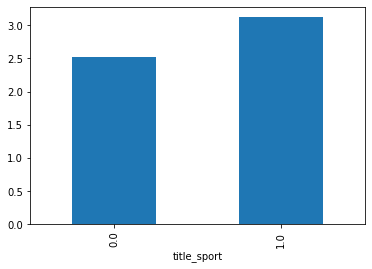

In [68]:
meta.groupby("title_sport")["rating"].mean().plot(kind='bar')

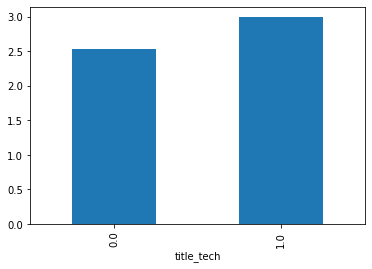

In [69]:
meta.groupby("title_tech")["rating"].mean().plot(kind='bar')

In [70]:
list(title_cat)

['title_clean',
 'title_colour',
 'title_animal',
 'title_sport',
 'title_paranormal',
 'title_place',
 'title_tech',
 'title_death',
 'title_mystery',
 'title_person',
 'title_ethnic',
 'title_fire',
 'title_danger',
 'title_treasure',
 'id']